# Climate Overview for Energy Modelling

Initial step to perform energy modelling is to get an overview of the climate data available for the region of interest. This notebook provides a guide to download and process ERA5-Land monthly data using the CDS API.


## 0. Getting ERA5-Land monthly via Python API

> You need to install the `cdsapi` package to use this notebook.

You can install it using `pip install cdsapi`, but you also need to register on the [Climate Data Store](https://cds.climate.copernicus.eu/api-how-to) and get your API key.
You need to do that only once, and it is valid for all future downloads.

The key should be saved in the `~/.cdsapirc` file in your home directory, but everything is explained in the link above.


In [1]:
import cdsapi
import timeit
import os
from utils import *
import xarray as xr
import zipfile
from matplotlib import pyplot as plt

### 1. Fill in the parameters

You only need to fill 3 information below to download the data and extract you need.

1. Define the region of interest using ISO A2 codes within the `ISO_A2` list.
2. Specify the start and end years for the data collection.
3. List the variables you want to download from the ERA5-Land dataset in the `variables_list`.

In [2]:
ISO_A2 = ['AO', 'CD', 'CG']

start_year, end_year = 1950, 2025                                           # from 1950

variables_list = ['2m_temperature',
                  'total_precipitation'
                 ]# to present year

#### Processing parameters
- Prepare the folder structure
- Data will be downloaded in the `climatic/era5_api` folder
- Extracted data will be saved in the `climatic/era5_extract` folder
- Output data will be saved in the `climatic/output` folder
- Data will be downloaded from the ERA5-Land monthly means dataset

In [3]:

# Create folder structure
folder = 'climatic'
if not os.path.exists(folder): os.mkdir(folder)
folder_api = os.path.join(folder, 'era5_api')
if not os.path.exists(folder_api): os.mkdir(folder_api)
folder_extract = os.path.join(folder, 'era5_extract')
if not os.path.exists(folder_extract): os.mkdir(folder_extract)
folder_output = os.path.join(folder, 'output')
if not os.path.exists(folder_output): os.mkdir(folder_output)
folder_output = os.path.join(folder_output, '_'.join(ISO_A2))
if not os.path.exists(folder_output): os.mkdir(folder_output)

# Define the dataset
dataset_name = 'reanalysis-era5-land-monthly-means'# 'reanalysis-era5-land'

# Define the API client variable
variable_name = {
    'total_precipitation': 'tp',
    'surface_runoff': 'sro',
    'runoff': 'ro',
    'snow_depth_water_equivalent': 'sd',
    '2m_temperature': 't2m',
    'potential_evaporation': 'pev',
    'total_evaporation': 'e'
}

#
temp = '_'.join([variable_name[variable] for variable in variables_list])
downloaded_files = {iso: f'{dataset_name}_{iso}_{start_year}_{end_year}_{temp}.zip' for iso in ISO_A2}
downloaded_files = {iso: os.path.join(folder_api, file) for iso, file in downloaded_files.items()}
print(f'Files will be download in: {folder_api}, files: {downloaded_files}')

# Define the bounding box for each ISO A2 code
locations = {iso: get_bbox(iso) for iso in ISO_A2}
print(f'Locations: {locations}')

Files will be download in: climatic/era5_api, files: {'AO': 'climatic/era5_api/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.zip', 'CD': 'climatic/era5_api/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.zip', 'CG': 'climatic/era5_api/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.zip'}
Locations: {'AO': (11.66939414300009, -18.031404723999884, 24.061714315000103, -4.391203714999932), 'CD': (12.210541212000066, -13.45835052399994, 31.280446818000087, 5.375280253000085), 'CG': (11.114016304109821, -5.019630835999919, 18.642406860000023, 3.7082760620000528)}


### 2. Automatic download from the API Climate Data Store

By default, the data will be downloaded in the `climatic/era5_api` folder. If you want to change the folder, please change the `folder_api` variable above.
It will be downloaded as a zip file including `.grib`files. Includes all monthly means for the specified period.

In [4]:
years = [ str(start_year +i ) for i in range(end_year - start_year + 1)]

# Create folder if not exists
if not os.path.exists(folder_api): os.mkdir(folder_api)

for (iso, (long_west, lat_south, long_east, lat_north)) in locations.items():

    downloaded_file = downloaded_files[iso]

    print(f'Processing {iso} with bbox: {long_west}, {lat_south}, {long_east}, {lat_north}')
    if not os.path.exists(downloaded_file):
        print('Process started. Please wait the ending message ... ')
        start = timeit.default_timer()
        c = cdsapi.Client()

        c.retrieve(
            dataset_name,
            {
                #'format': 'netcdf',
                'format': 'grib',
                'product_type': 'monthly_averaged_reanalysis',
                'variable': variables_list,
                'year': years,
                'month': [ '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12' ],
                'time': '00:00',
                'area': [ lat_south, long_west, lat_north, long_east ],
            }, downloaded_file
            )

        stop = timeit.default_timer()
        print('Process completed in ', (stop - start)/60, ' minutes')
    else:
        print('File already exists.')

Processing AO with bbox: 11.66939414300009, -18.031404723999884, 24.061714315000103, -4.391203714999932
Process started. Please wait the ending message ... 


2025-06-20 15:45:52,519 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-20 15:45:52,520 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-20 15:45:52,521 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-20 15:45:52,866 INFO Request ID is 3135abae-fba2-4803-b088-418e9f12fe96
2025-06-20 15:45:52,939 INFO status has been updated to accepted
2025-06-20 15:46:01,506 INFO status has been updated to running
2025-06-20 15:46:06,651 INFO status has been updated to successful


Process completed in  0.3660811944496042  minutes
Processing CD with bbox: 12.210541212000066, -13.45835052399994, 31.280446818000087, 5.375280253000085
Process started. Please wait the ending message ... 


2025-06-20 15:46:19,373 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-20 15:46:19,373 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-20 15:46:19,374 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-20 15:46:19,510 INFO Request ID is ebced4ec-2dcd-42a7-9a1b-475756dfff1c
2025-06-20 15:46:19,553 INFO status has been updated to accepted
2025-06-20 15:46:28,443 INFO status has been updated to successful
2025-06-20 15:46:32,195 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://fo

Process completed in  0.37887479791728157  minutes
Processing CG with bbox: 11.114016304109821, -5.019630835999919, 18.642406860000023, 3.7082760620000528
Process started. Please wait the ending message ... 


2025-06-20 15:46:32,391 INFO Request ID is 515ec39b-f827-498e-b06d-d56548650089
2025-06-20 15:46:32,438 INFO status has been updated to accepted
2025-06-20 15:46:37,918 INFO status has been updated to running
2025-06-20 15:46:41,346 INFO status has been updated to accepted
2025-06-20 15:46:54,109 INFO status has been updated to successful
                                                                                          

Process completed in  0.38346572361673076  minutes


### 3. Extracting and formatting the data

In [6]:
dataset = {}
for iso, downloaded_file in downloaded_files.items():
    print(f'Processing {iso} with file: {downloaded_file}')
    data = extract_data(downloaded_file, step_type=True, extract_to=folder_extract)

    # Calculate resolution and add units
    calculate_resolution_netcdf(data, lat_name='latitude', lon_name='longitude')

    for var in data.data_vars:
        print(f"{var}: {data[var].attrs['units']}")

    # Convert units if necessary
    data = convert_dataset_units(data)

    # Export transformed data to NetCDF for future analysis
    data.to_netcdf(os.path.join(folder_output, f"{ os.path.splitext(os.path.basename(downloaded_file))[0]}.nc"))

    dataset.update({iso: data})


Processing AO with file: climatic/era5_api/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.zip


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Opening GRIB file: climatic/era5_extract/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.grib


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file
Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Opening GRIB file: climatic/era5_extract/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.grib


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_AO_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Spatial resolution: 0.10000813008130116° lon x -0.09999999999999964° lat
Approximate spatial resolution:
10.89 km (lon_name) x -11.10 km (lat_name) at -11.23° lat
Temporal resolution: 31 days
t2m: K
tp: m
Processing CD with file: climatic/era5_api/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.zip


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Opening GRIB file: climatic/era5_extract/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.grib


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file
Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Opening GRIB file: climatic/era5_extract/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.grib


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CD_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Spatial resolution: 0.10000526315789493° lon x -0.09999999999999964° lat
Approximate spatial resolution:
11.07 km (lon_name) x -11.10 km (lat_name) at -4.06° lat
Temporal resolution: 31 days
t2m: K
tp: m


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Processing CG with file: climatic/era5_api/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.zip
Opening GRIB file: climatic/era5_extract/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.grib


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file
Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Opening GRIB file: climatic/era5_extract/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.grib


Ignoring index file 'climatic/era5_extract/reanalysis-era5-land-monthly-means_CG_1950_2025_t2m_tp.grib.5b7b6.idx' older than GRIB file


Spatial resolution: 0.10001333333333307° lon x -0.10000000000000009° lat
Approximate spatial resolution:
11.10 km (lon_name) x -11.10 km (lat_name) at -0.67° lat
Temporal resolution: 31 days
t2m: K
tp: m


### 4. Visualization of climate data

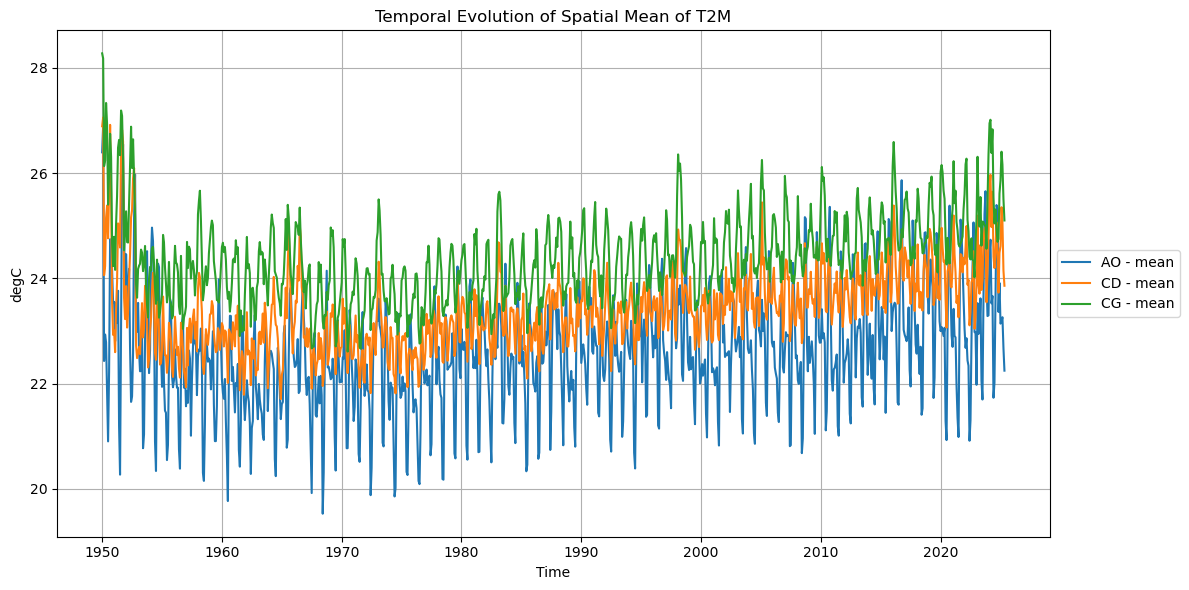

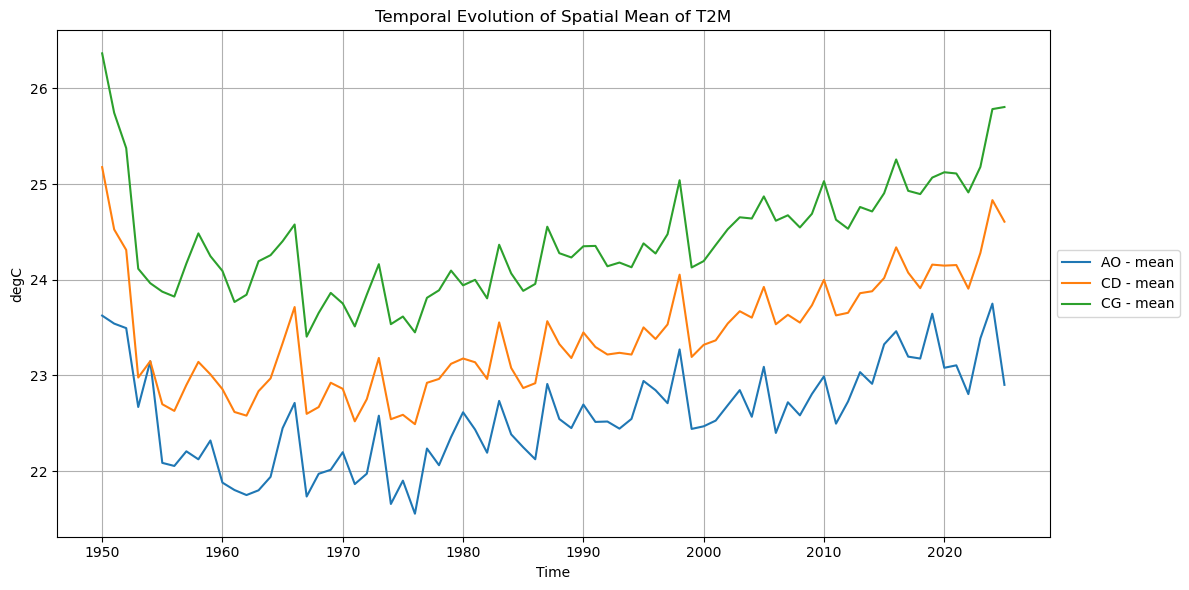

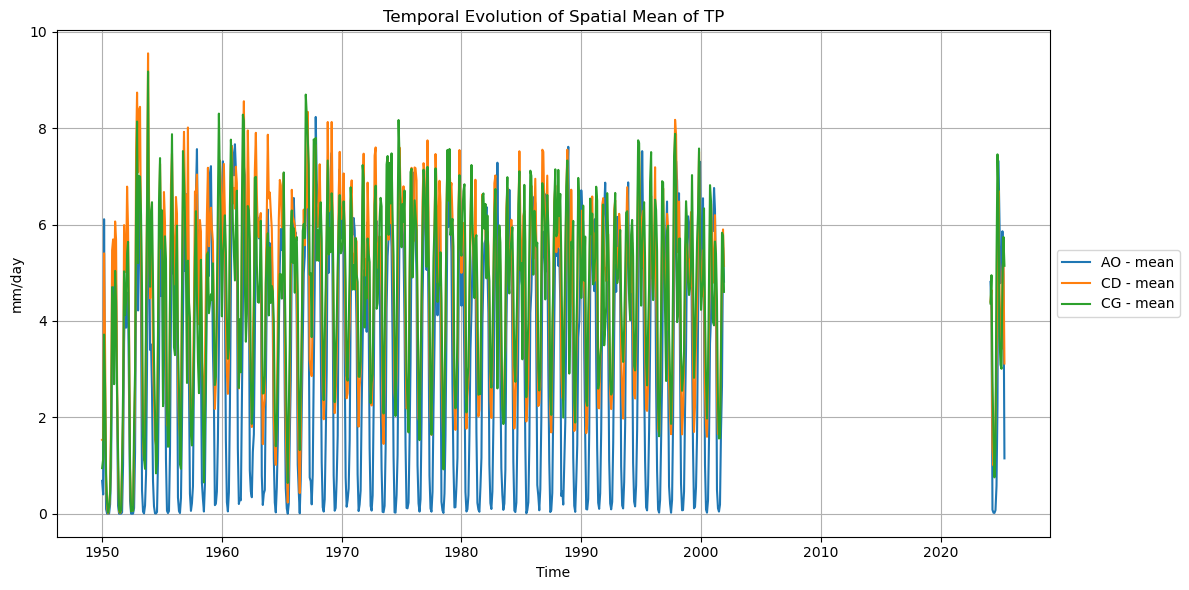

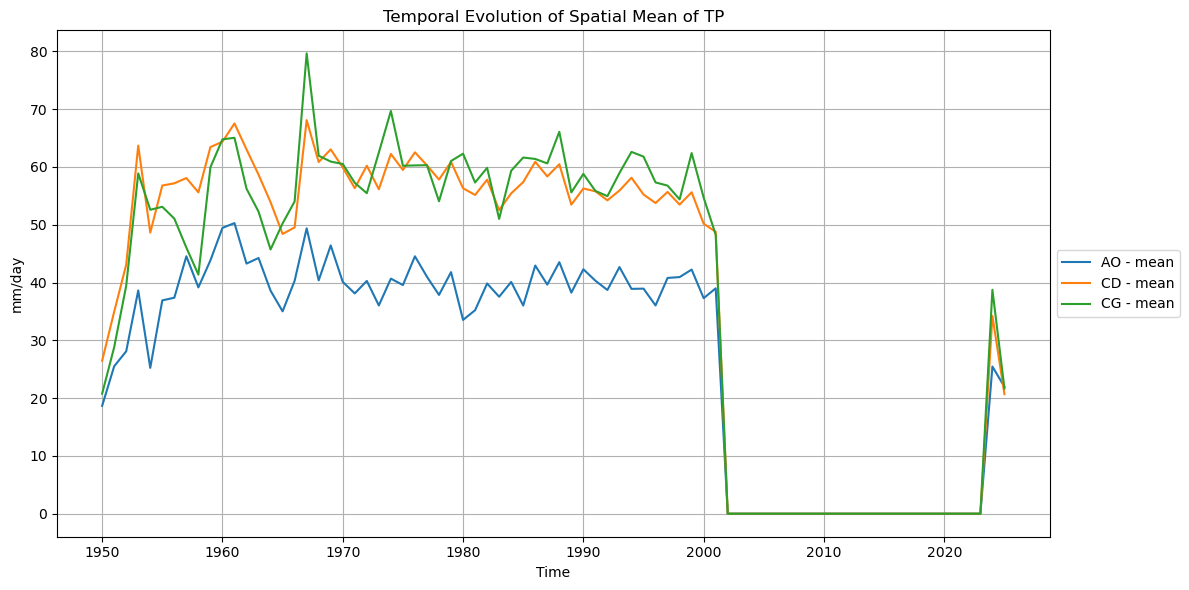

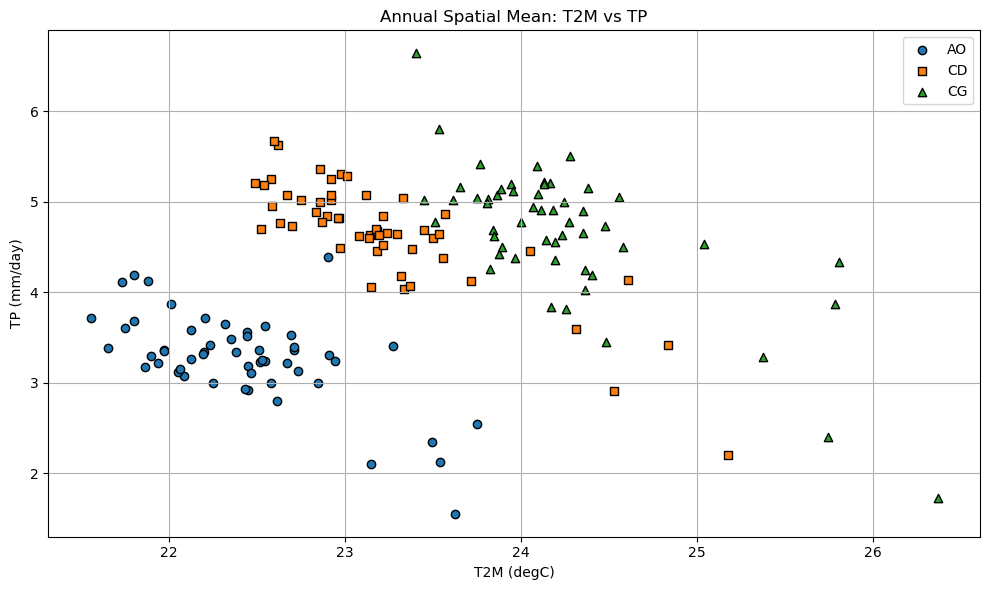

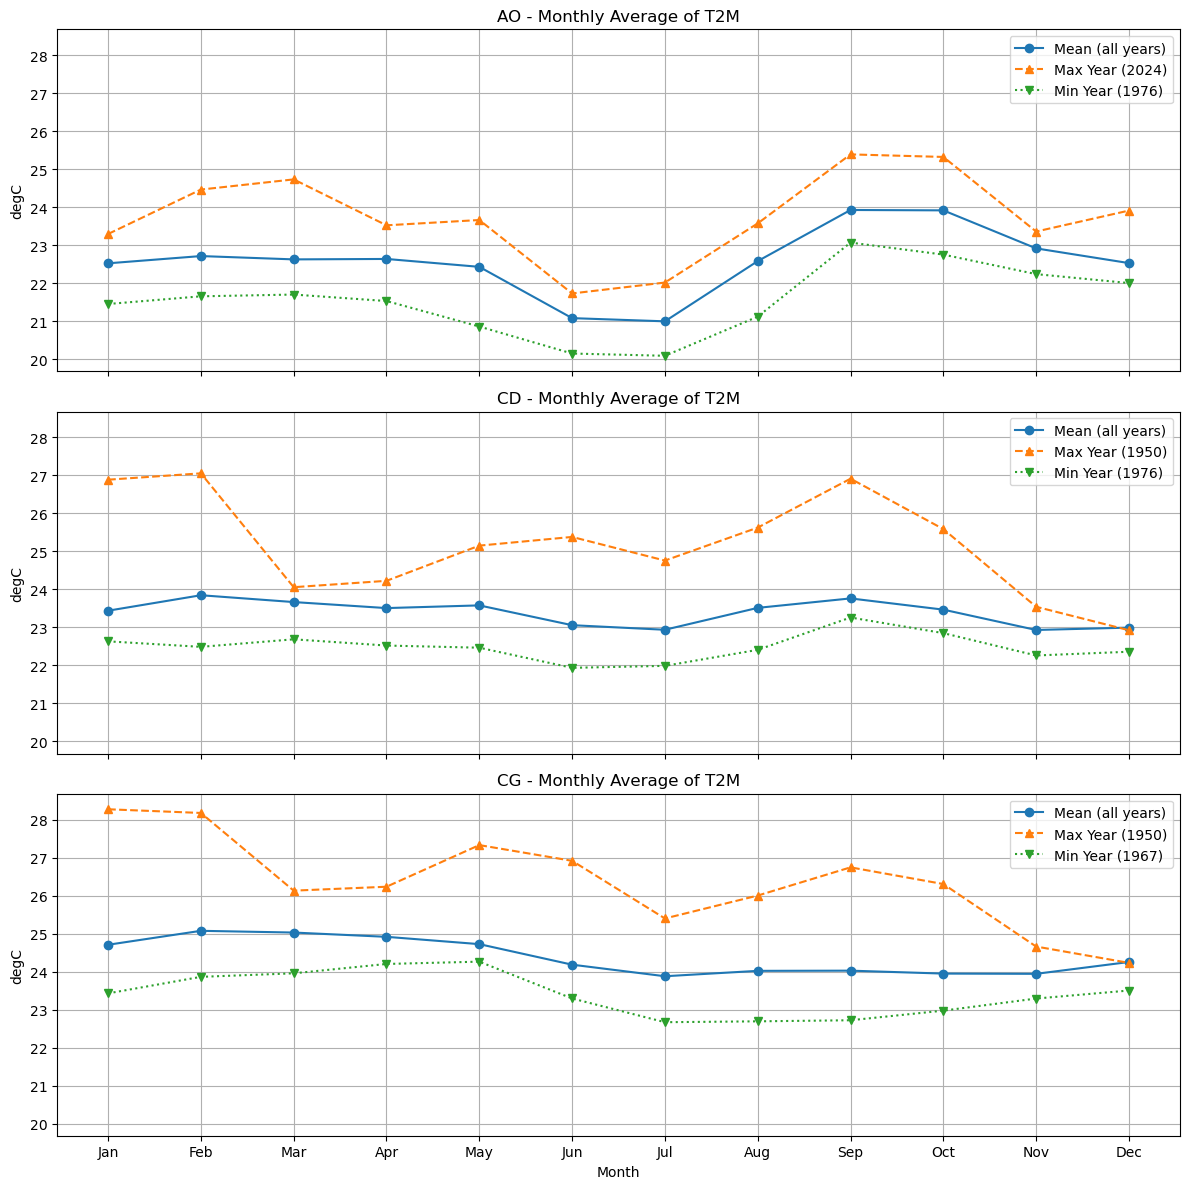

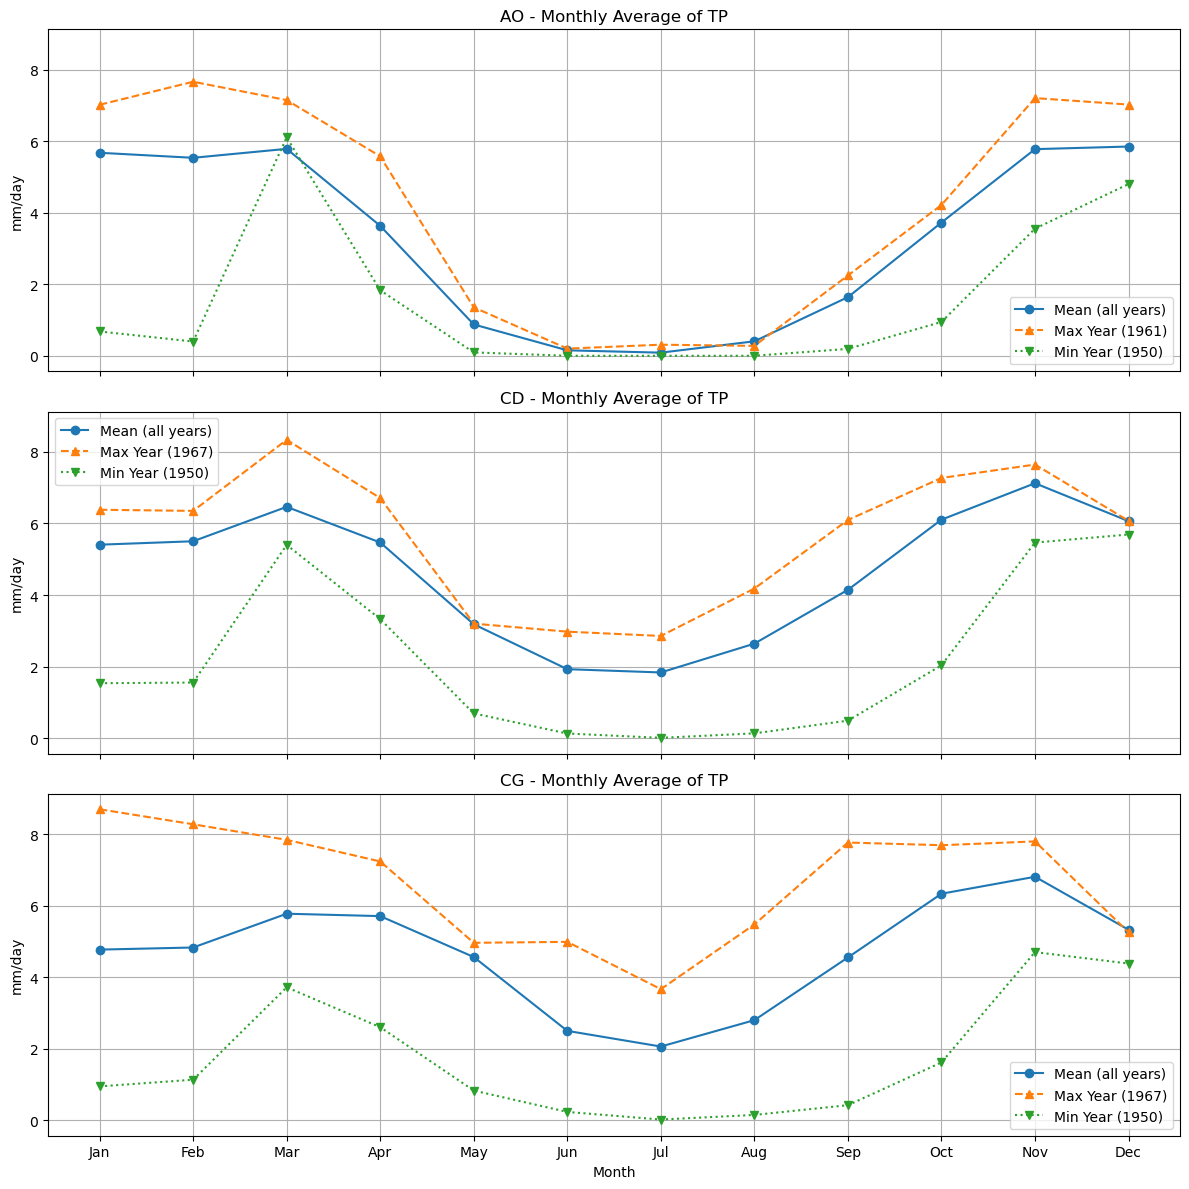

Processing AO
Processing CD
Processing CG


In [7]:
# Remove only to make the Figures in the notebook
folder_output = None

# Plotting spatial mean timeseries for all variables
for var in variables_list:
    # Find the indirect from the variable name
    plot_spatial_mean_timeseries_all_iso(dataset, var=variable_name.get(var, var), folder=folder_output)

    if var == '2m_temperature':
        agg = 'avg'
    elif var == 'total_precipitation':
        agg = 'sum'
    else:
        agg = None

    plot_spatial_mean_timeseries_all_iso(dataset, var=variable_name.get(var, var), agg=agg, folder=folder_output)

# Plotting scatter plot of annual spatial means
scatter_annual_spatial_means(dataset, var_x='t2m', var_y='tp', folder=folder_output)

# Plotting monthly average for each variable
plot_monthly_mean(dataset, "t2m", lat_name='latitude', lon_name='longitude', folder=folder_output)
plot_monthly_mean(dataset, "tp", lat_name='latitude', lon_name='longitude', folder=folder_output)

# Plotting monthly climatology for each variable
for iso, data in dataset.items():
    print(f'Processing {iso}')
    plot_monthly_climatology_grid(data, "t2m", filename=os.path.join(folder, f'monthly_climatology_{iso}_{var}.jpg'))
    plot_monthly_climatology_grid(data, "tp", filename=os.path.join(folder, f'monthly_climatology_{iso}_{var}.jpg'))
